# Colocating oceanic profiles with tropical cyclones

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import helpers
    
API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu/'

## Search and plot a tropical cyclone

Let's start by downloading Argovis' information for tropical cyclone Maria in 2017, and plotting it. If you are interested in another tropical cyclone at a different time, please edit tc_param below. If you don't know what cyclone name you want, or would rather search by cyclone ID, see the appendix at the end of this notebook for discovery options.

In [2]:
tc_param = {
    'startDate': '2017-09-01T00:00:00Z',
    'endDate': '2017-10-01T00:00:00Z',
    'name': 'MARIA',
    'data': 'wind,surface_pressure'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)

/usr/local/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:402: ShapelyDeprecationWarning: Iteration over multi-pa

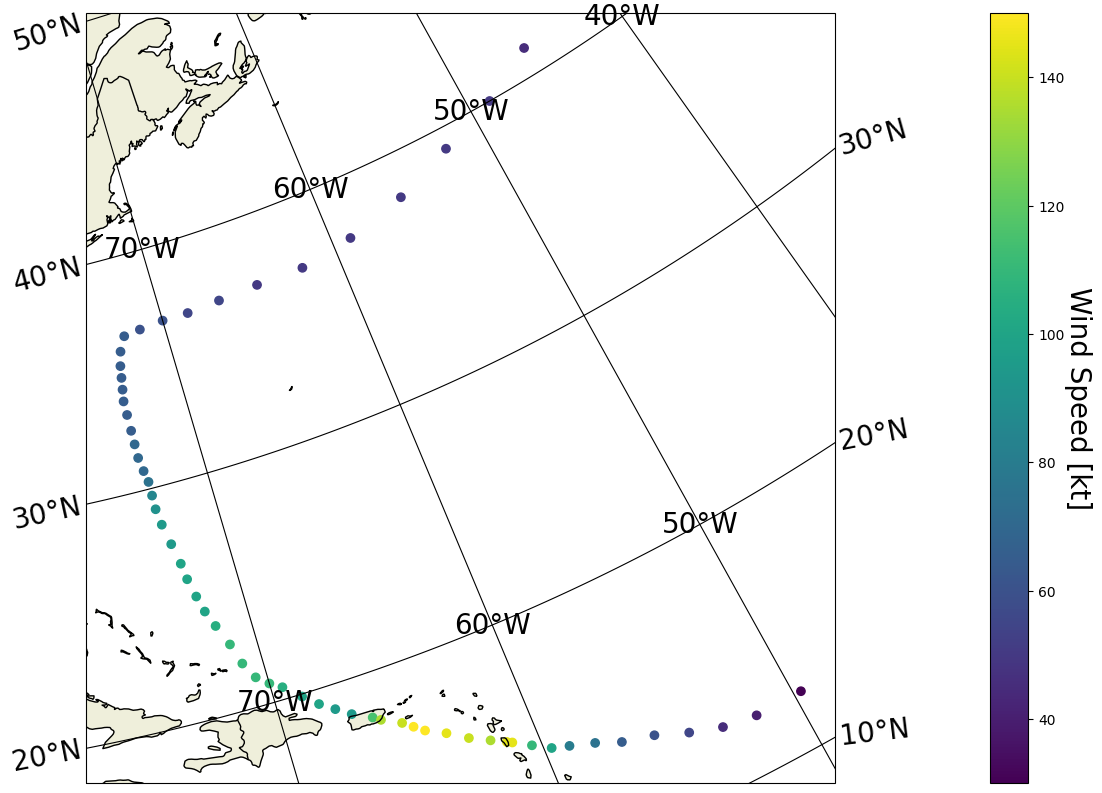

In [3]:
tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][0][0] for x in tc]
helpers.simple_map(tc_lon, tc_lat, z=tc_wind, zlabel='Wind Speed [kt]')

## Search and plot colocated Argo data

Next lets see if there were any Argo profiles close by any of the tropical cyclone track points, and add them to our plot (the colocation strategy is indicated in "colo_argo"):

In [4]:
argo = []

for h in tc:
    colo_argo = {
        'center': str(h['geolocation']['coordinates'][0]) + ',' + str(h['geolocation']['coordinates'][1]),
        'radius': 52,
        'startDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=-6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'endDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'data': 'temperature,salinity'
    }
    p = avh.query('argo', options=colo_argo, apikey=API_KEY, apiroot=API_PREFIX)

    if len(p) == 0:
        argo.append(None)
    else:
        print('Profile found adjacent to', h['geolocation']['coordinates'][0], h['geolocation']['coordinates'][1])
        argo.append(p)

Profile found adjacent to -45.60000000000002 41.2
Profile found adjacent to -59 37.4
Profile found adjacent to -64.60000000000002 37
Profile found adjacent to -73.10000000000002 33.9
Profile found adjacent to -72.89999999999998 29.7
Profile found adjacent to -72.89999999999998 29.1
Profile found adjacent to -70.89999999999998 21.9
Profile found adjacent to -70.5 21.2
Profile found adjacent to -70 20.8
Profile found adjacent to -61.30000000000001 15.4
Profile found adjacent to -61.10000000000002 15.3


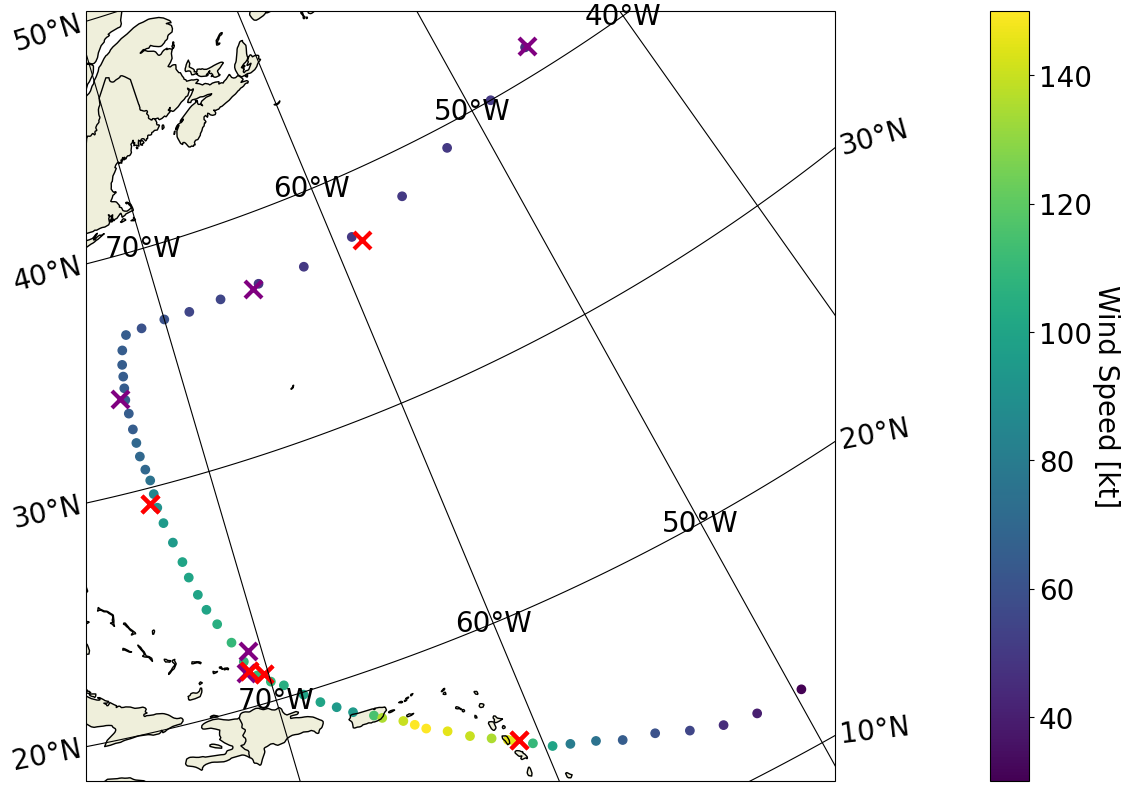

In [5]:
floats = []
colorBefore = 'red'
colorAfter = 'purple'
bracket_points = []
for i, colo in enumerate(argo):
    buddyBefore = False
    buddyAfter = False
    if colo:
        hurrtime = avh.parsetime(tc[i]['timestamp']) 
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            buddy={
                "lon": p['geolocation']['coordinates'][0],
                "lat": p['geolocation']['coordinates'][1],
            }
            if ptime < hurrtime:
                buddy['color'] = colorBefore
                buddyBefore = True
            else:
                buddy['color'] = colorAfter
                buddyAfter = True
            floats.append(buddy)
        if buddyBefore and buddyAfter:
            bracket_points.append(i)
helpers.simple_map(tc_lon, tc_lat, secondaries=floats, z=tc_wind, zlabel='Wind Speed [kt]')

In the plot above, red X marks profiles collected before the hurricane passed, and purple X marks profiles collected after. Next let's plot the temperatures and salinities found for these profiles, grouping plots by proximate hurricane track point:

In [6]:
def hurrplot(bracket_points, var, maxpress=150, line=False):
    markers = ['.', 'v', 'P', 'X']
    markernames = ['dot', 'triangle', 'plus', 'x']
    fnt_sz = 40
    if var == 'temperature':
        var_units = ', degC'
    elif var == 'salinity':
        var_units = ', psu'
    for i in bracket_points:
        colo = argo[i]
        hurrtime = avh.parsetime(tc[i]['timestamp'])
        hurrspeed = tc[i]['data'][0][0]
        hurrpress = tc[i]['data'][1][0]
        hurrlon = tc[i]['geolocation']['coordinates'][0]
        hurrlat = tc[i]['geolocation']['coordinates'][1]
        annotation = 'Hurricane track longitude: ' + str(hurrlon) + '\nHurricane track latitude: ' + str(hurrlat) + '\nHurricane track timestamp: ' + str(hurrtime) + '\nHurricane wind speed [kt]: ' + str(hurrspeed) + '\nHurricane surface pressure [mb]: ' + str(hurrpress)
        np = 0
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            c = colorBefore
            if ptime > hurrtime:
                c = colorAfter
            time2hurricane = str(hurrtime.replace(microsecond=0) - ptime.replace(microsecond=0))
            pressure = p['data'][p['data_info'][0].index('pressure')]
            d = p['data'][p['data_info'][0].index(var)]
            cutoff = next((i for i,v in enumerate(pressure) if v>maxpress))-1
            psub = pressure[0:cutoff]
            dsub = d[0:cutoff]
            
            if np == 0:
                fig = plt.figure(figsize=(10,10))
                ax  = fig.add_subplot(111)
            
            ax.scatter(dsub, psub, c=[c]*len(psub), marker=markers[np%len(markers)])
            if line:
                ax.plot(dsub, psub, c=c,linewidth=2)
            #ax.set(xlabel=var+var_units, ylabel='Pressure, dbar')
            plt.xlabel(var+var_units, fontsize=fnt_sz)
            plt.ylabel('pressure, dbar', fontsize=fnt_sz)
            ax.tick_params(axis='both', which='major', labelsize=fnt_sz)
            annotation += '\n\nArgo profile ' + p['_id'] + '\nmarker: ' + markernames[np%len(markers)]  + '\nProfile longitude: ' + str(p['geolocation']['coordinates'][0]) + '\nProfile latitude: ' + str(p['geolocation']['coordinates'][1]) + '\nProfile timestamp: ' + str(p['timestamp'])
            np+=1
        ax.invert_yaxis()
        ax.text(ax.get_xlim()[1] + 0.05*(ax.get_xlim()[1]-ax.get_xlim()[0]),0.9*maxpress, annotation, fontsize=fnt_sz) 

In the plots below, red profiles were collected before the passage of the TC, purple profiles after. We only make the plots for those locations on the TC track where at least one profile is available both before and after (as we are interested in looking at TC induced changes in upper ocean properties). The indices for these points are stored in the variable bracket_points. For now, we only make the plot for the first index stored in the variable bracket_points: to change this and make the plot for all the cases, use the lines in the comments below.

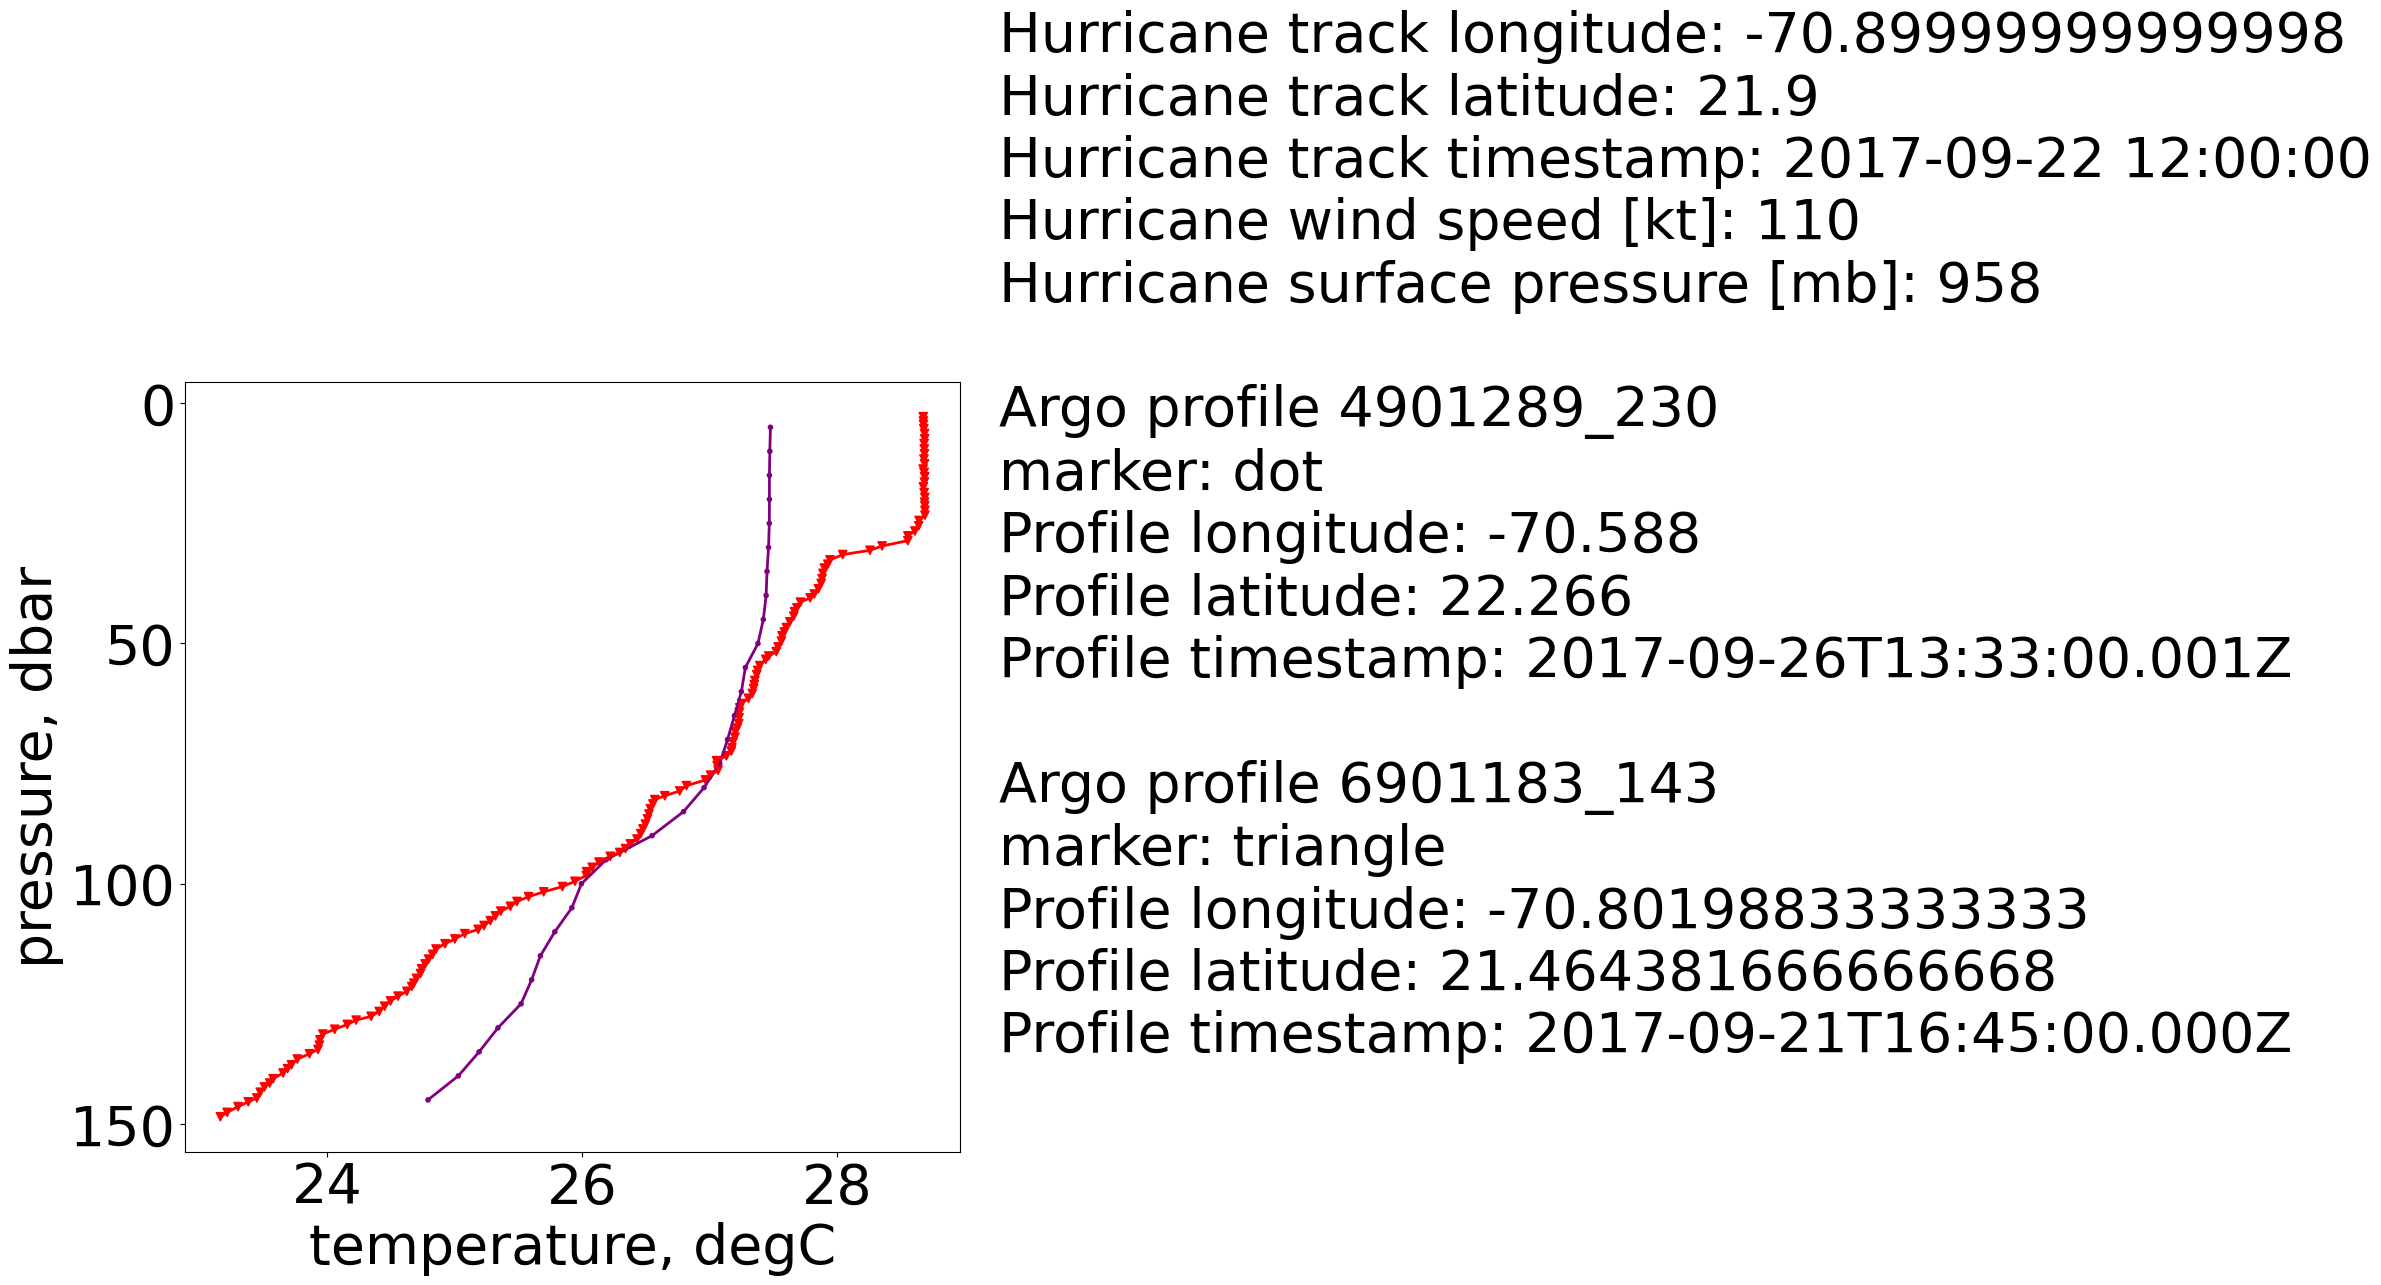

In [7]:
hurrplot([bracket_points[0]], 'temperature',line=True)

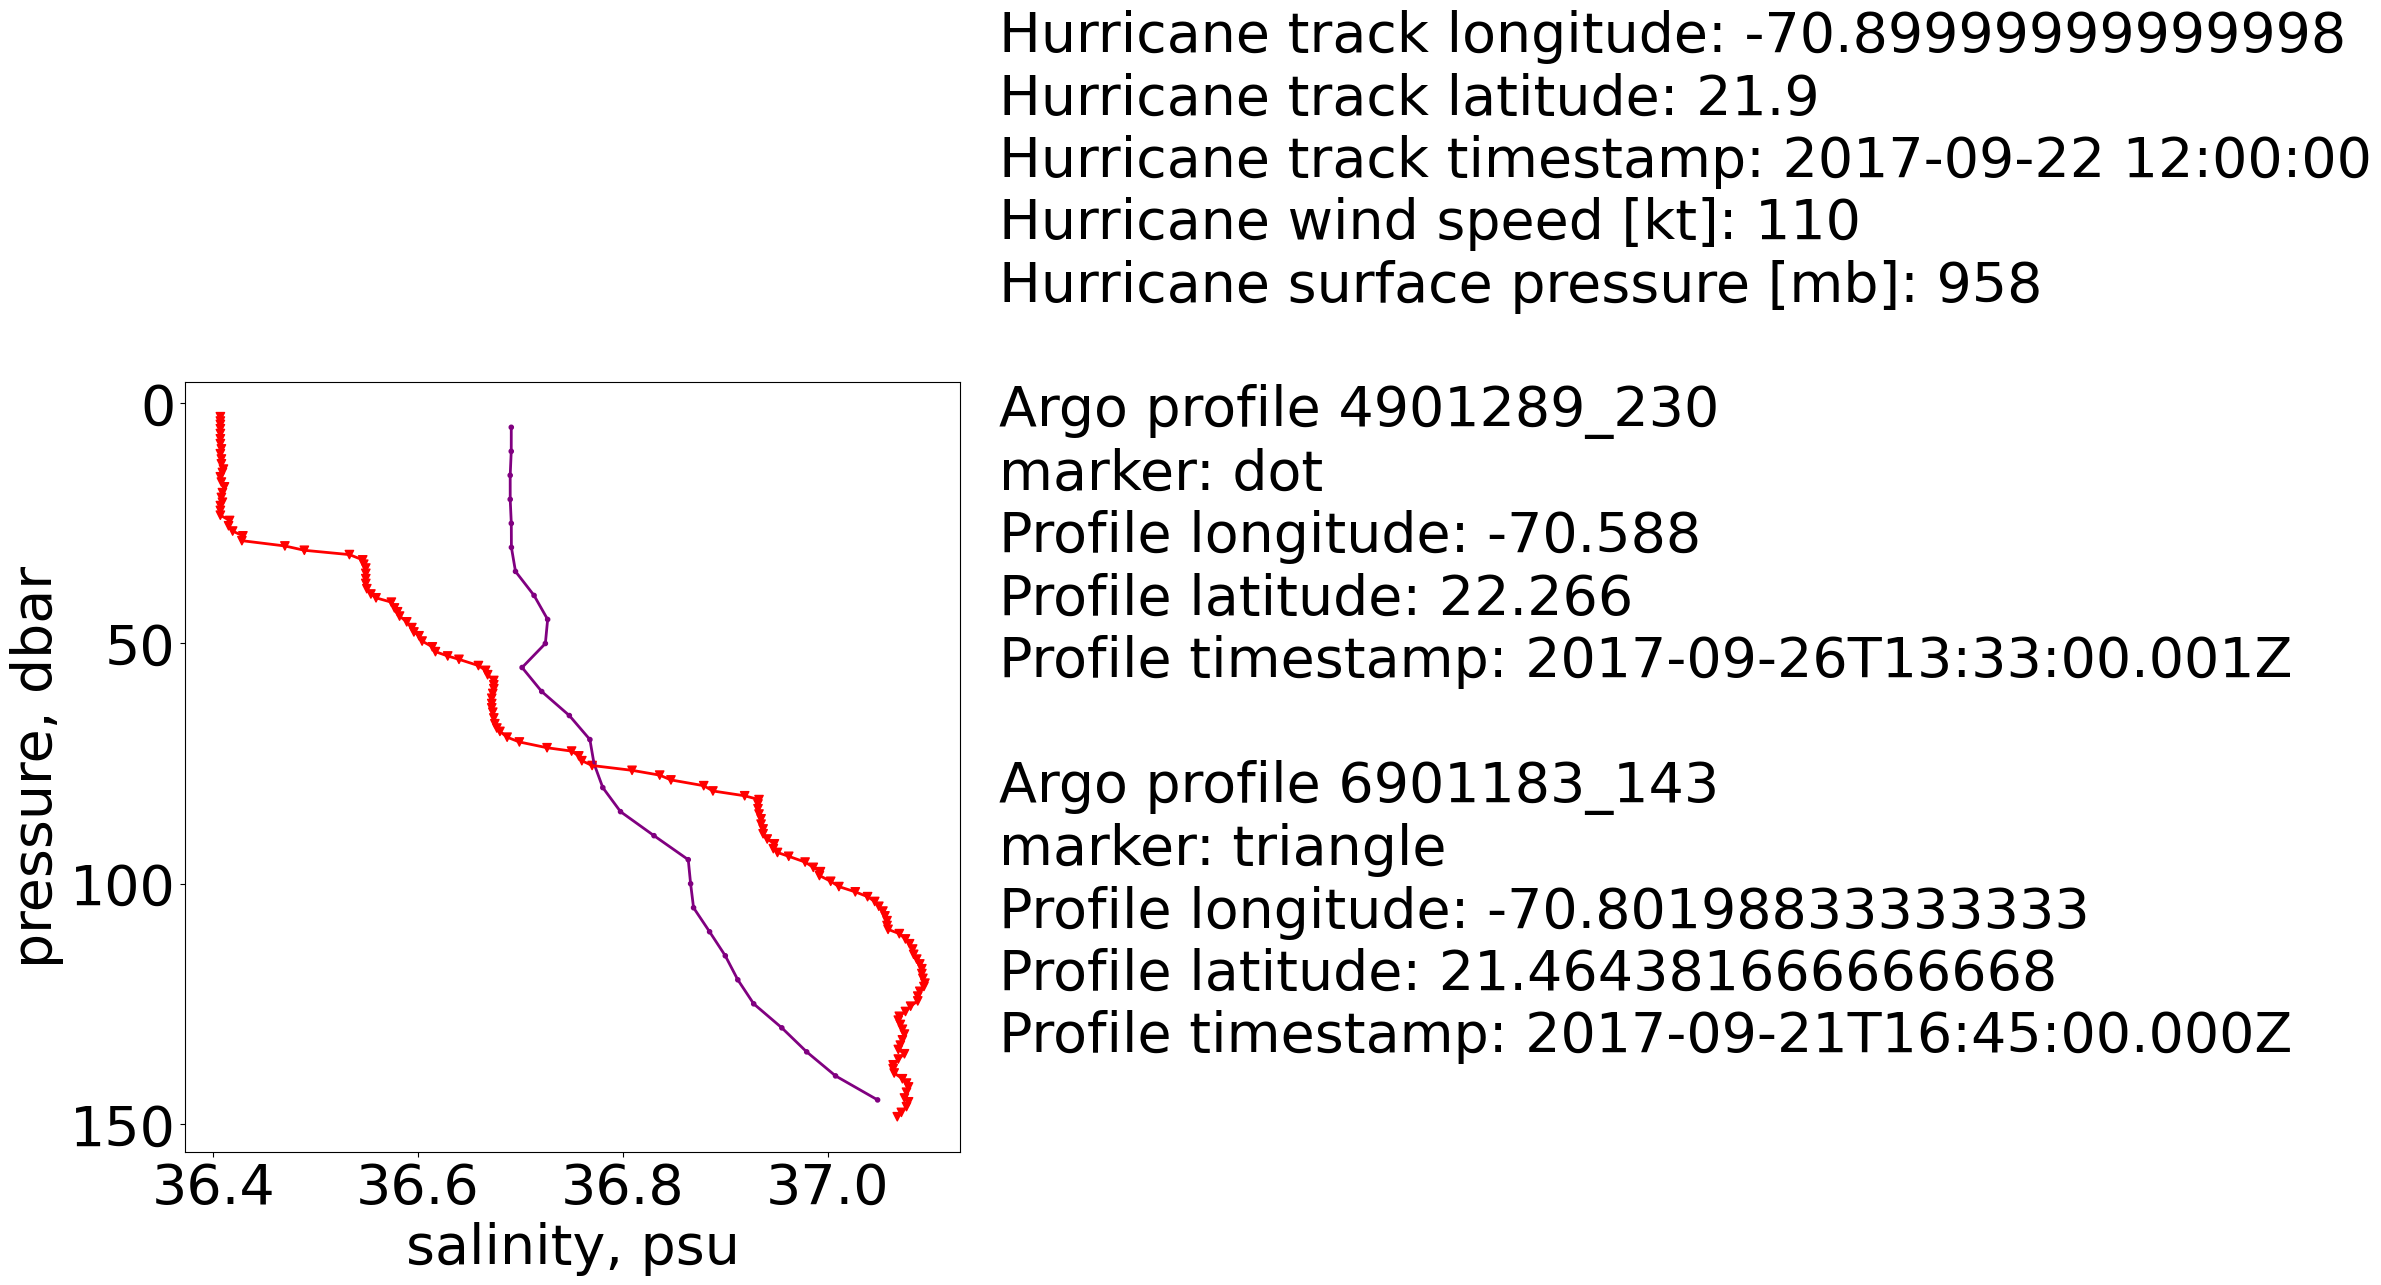

In [8]:
hurrplot([bracket_points[0]], 'salinity',line=True)

## Appendix: identifying tropical cyclones in Argovis

In the above, we looked at 2017's tropical cyclone Maria with some foreknowledge of its name and rough time period. What if we don't have such insight, and want to identify cyclone events purely by temporospatial query, or discover what cyclones are available in Argovis? This is the question we investigate below.

Perhaps we are interested in cyclones in the Gulf of Mexico in 2020. We might search as follows:

In [9]:
gulf_region = [[-83.06,31.86],[-100.11,31.74],[-99.47,17.65],[-81.65,17.25],[-83.06,31.86]]

tc_param = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'polygon': gulf_region,
    'data': 'all'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)

Let's plot what we got, just to look at it:

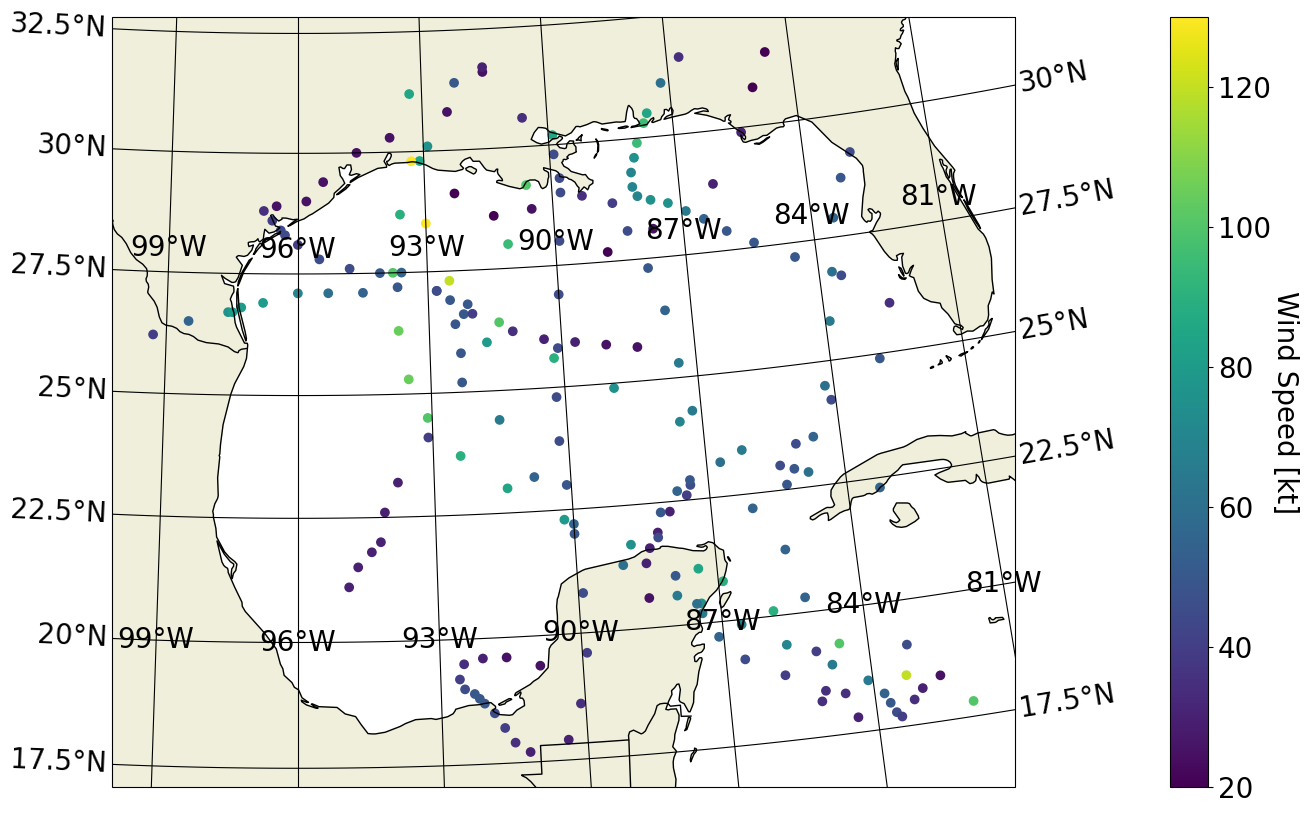

In [10]:
tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][0][0] for x in tc]
helpers.simple_map(tc_lon, tc_lat, z=tc_wind, zlabel='Wind Speed [kt]')

Unsurprisingly, this looks like numerous different cyclones. The `metadata` record identifies distinct cyclones; let's get a list:

In [11]:
cyclones = list(set([x['metadata'][0] for x in tc]))
print(cyclones)

['AL192020', 'AL142020', 'AL282020', 'AL082020', 'AL032020', 'AL252020', 'AL132020', 'AL222020', 'AL292020', 'AL062020', 'AL262020']


Perhaps we're interested in a particular one of these cyclones; we can filter for data records using the metadata identifier, which for tropical cyclones uniquely corresponds to distinct cyclones:

In [12]:
tc_param = {
    'metadata': 'AL032020',
    'data': 'all'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX, verbose=True)

https://argovis-api.colorado.edu/tc?metadata=AL032020&data=all


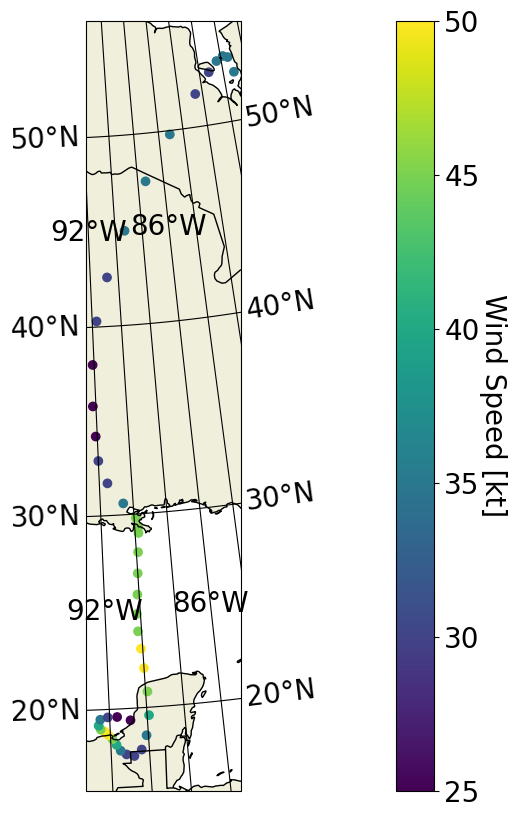

In [13]:
tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][0][0] for x in tc]
helpers.simple_map(tc_lon, tc_lat, z=tc_wind, zlabel='Wind Speed [kt]')

If instead we'd rather work by cyclone name, we first need to fetch the metadata documents that correspond to our region of interest; we can do this by adding the `batchmeta` flag to our original request:

In [14]:
tc_param = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'polygon': gulf_region,
    'data': 'all',
    'batchmeta': True
}

tc_meta = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)
cyclone_names = list(set([x['name'] for x in tc_meta]))
cyclone_names.sort()
cyclone_names

['BETA',
 'CRISTOBAL',
 'DELTA',
 'ETA',
 'FAY',
 'GAMMA',
 'HANNA',
 'LAURA',
 'MARCO',
 'SALLY',
 'ZETA']

We could then search by name just like we did for Maria at the beginning of this notebook.